In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import numpy as np

# custom dataloader
from src.dataloader import DIV2KDataModule
# module to get VGG features
from src.vgg_wrapper import VGGFeatureExtractor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def bicubic_baseline(lr_image):
    """
    Upscale LR image to HR using bicubic interpolation
    Args:
        lr_image: Tensor of shape (B, C, H, W) or (C, H, W)
    Returns:
        sr_image: Upscaled image with 4x resolution
    """
    if lr_image.dim() == 3:
        lr_image = lr_image.unsqueeze(0)
    
    # Upscale 4x (64x64 -> 256x256)
    sr_image = F.interpolate(
        lr_image,
        scale_factor=4,
        mode='bicubic',
        align_corners=False
    )
    
    # Clamp to [0, 1] range
    sr_image = torch.clamp(sr_image, 0, 1)
    
    return sr_image


In [ ]:
# set up dataloader
dataloader = DIV2KDataModule(batch_size=32, num_workers=4)
dataloader.setup()

In [ ]:
# set up feature extractor
vgg_extractor = VGGFeatureExtractor().to(device)
vgg_extractor.eval()

In [ ]:
# test baseline
mse_loss_fn = nn.MSELoss()

for lr_imgs, hr_imgs in dataloader.test_dataloader():
    lr_imgs = lr_imgs.to(device)
    hr_imgs = hr_imgs.to(device)
    
    with torch.no_grad():
        sr_imgs = bicubic_baseline(lr_imgs)
        
        # Compute VGG features
        sr_features = vgg_extractor(sr_imgs)
        hr_features = vgg_extractor(hr_imgs)
        
        # Compute MSE loss in feature space
        loss = mse_loss_fn(sr_features, hr_features)
        
    print(f"Bicubic Baseline VGG Feature MSE Loss: {loss.item()}")
    break # do it for 1 batch

Bicubic Baseline VGG Feature MSE Loss: 0.19053831696510315


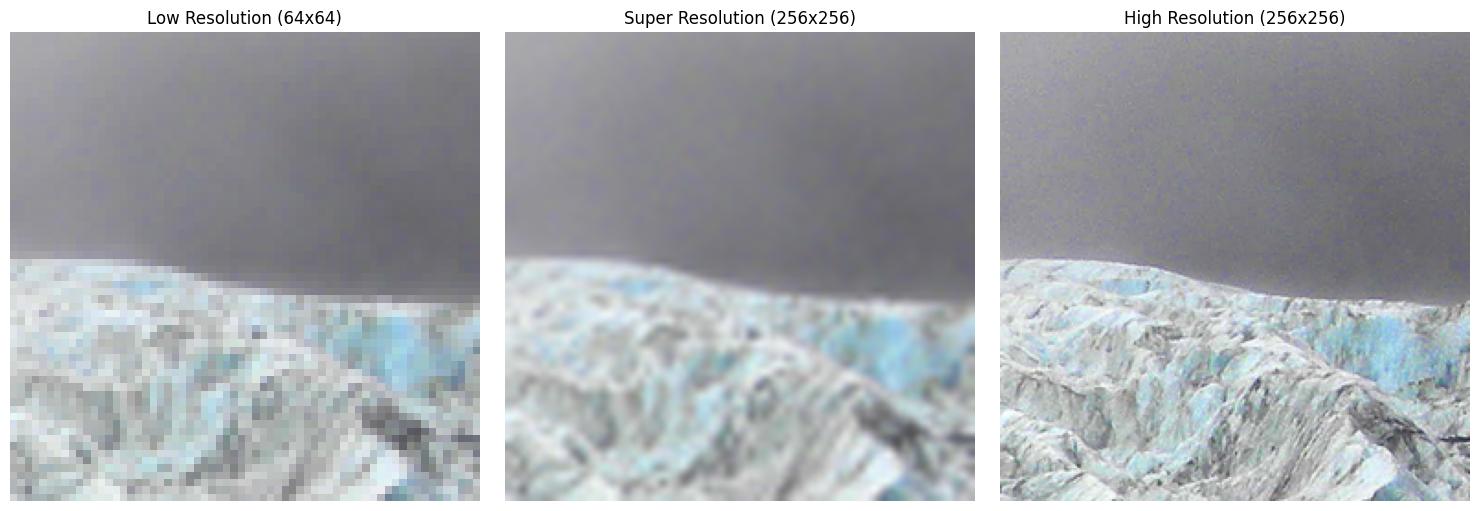

In [10]:
import matplotlib.pyplot as plt

# Select one example from the batch (e.g., first image)
idx = 2

lr_img = lr_imgs[idx].cpu().permute(1, 2, 0).numpy()
sr_img = sr_imgs[idx].cpu().permute(1, 2, 0).numpy()
hr_img = hr_imgs[idx].cpu().permute(1, 2, 0).numpy()

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(lr_img)
axes[0].set_title(f'Low Resolution ({lr_img.shape[0]}x{lr_img.shape[1]})')
axes[0].axis('off')

axes[1].imshow(sr_img)
axes[1].set_title(f'Super Resolution ({sr_img.shape[0]}x{sr_img.shape[1]})')
axes[1].axis('off')

axes[2].imshow(hr_img)
axes[2].set_title(f'High Resolution ({hr_img.shape[0]}x{hr_img.shape[1]})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# GAN: train first in train_pipeline.ipynb and save it, then load it here